<a href="https://www.kaggle.com/code/vweimer/jpx-adjusted-close-and-volume-and-features?scriptVersionId=96081798" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

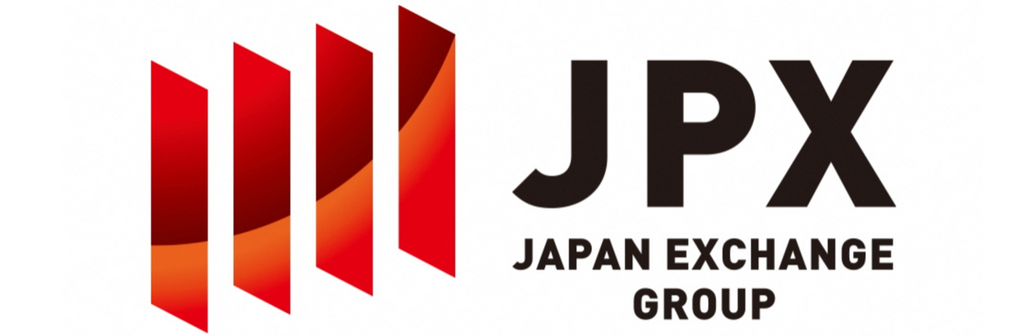

<span style="font-size:18px;"><span style="font-family:cursive;">
  <b>Author: Vincent Weimer <br>
      Date: 2022-05-19</b>
    </span>
  
<hr></hr> 

In [1]:
%%capture

## Import Libraries
import numpy as np # linear algebra
from numpy.random import seed 
import math 

import pandas as pd # data processing 
pd.options.display.max_rows = 1000
pd.options.display.max_seq_items = 2000
pd.options.display.float_format = '{:20,.2f}'.format
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

import datetime as dt
from decimal import ROUND_HALF_UP, Decimal

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mpl_dates
plt.rcParams.update({'font.size': 14})
import seaborn as sns
plt.style.use('seaborn')
sns.set_style('whitegrid')

import warnings # Supress warnings 
warnings.filterwarnings('ignore')

import statsmodels as s

## Import Datasets

In [2]:
%%time

## Import data
data_folder = "../input/jpx-tokyo-stock-exchange-prediction/"

def read_datasets(path):
    print('Loading Stock List...')
    stock_list = pd.read_csv(path + "stock_list.csv")
    display(stock_list.head())
    print('Loading Stock Prices ...')
    stock_prices = pd.read_csv(path + "train_files/stock_prices.csv")
    display(stock_prices.head())
    print('Loading Trades file...')
    trades = pd.read_csv(path + "train_files/trades.csv")
    display(trades.head())
    
    return stock_list, stock_prices, trades

stock_list, stock_prices, trades = read_datasets(data_folder)

Loading Stock List...


SecuritiesCode  EffectiveDate                                                  Name          Section/Products NewMarketSegment 33SectorCode                       33SectorName 17SectorCode 17SectorName NewIndexSeriesSizeCode NewIndexSeriesSize            TradeDate                Close         IssuedShares  MarketCapitalization  Universe0
0  1301            20211230       KYOKUYO CO.,LTD.                                      First Section (Domestic)  Prime Market     50           Fishery, Agriculture and Forestry  1            FOODS        7                      TOPIX Small 2            20,211,230.00             3,080.00        10,928,283.00    33,659,111,640.00   True     
1  1305            20211230       Daiwa ETF-TOPIX                                       ETFs/ ETNs                NaN              -            -                                  -            -            -                      -                        20,211,230.00             2,097.00     3,634,635,625.00 7,621,830,905,625.00   False    
2  1306            20211230       NEXT FUNDS TOPIX Exchange Traded Fund                 ETFs/ ETNs                NaN              -            -                                  -            -            -                      -                        20,211,230.00             2,073.50     7,917,718,452.00 16,417,389,210,222.00  False    
3  1308            20211230       Nikko Exchange Traded Index Fund TOPIX                ETFs/ ETNs                NaN              -            -                                  -            -            -                      -                        20,211,230.00             2,053.00     3,736,943,486.00 7,671,944,976,758.00   False    
4  1309            20211230       NEXT FUNDS ChinaAMC SSE50 Index Exchange Traded Fund  ETFs/ ETNs                NaN              -            -                                  -            -            -                      -                        20,211,230.00            44,280.00            72,632.00     3,216,144,960.00   False

Loading Stock Prices ...


RowId        Date  SecuritiesCode                 Open                 High                  Low                Close   Volume     AdjustmentFactor  ExpectedDividend  SupervisionFlag               Target
0  20170104_1301  2017-01-04  1301                       2,734.00             2,755.00             2,730.00             2,742.00  31400                   1.00 NaN                False                           0.00
1  20170104_1332  2017-01-04  1332                         568.00               576.00               563.00               571.00  2798500                 1.00 NaN                False                           0.01
2  20170104_1333  2017-01-04  1333                       3,150.00             3,210.00             3,140.00             3,210.00  270800                  1.00 NaN                False                           0.01
3  20170104_1376  2017-01-04  1376                       1,510.00             1,550.00             1,510.00             1,550.00  11300                   1.00 NaN                False                           0.01
4  20170104_1377  2017-01-04  1377                       3,270.00             3,350.00             3,270.00             3,330.00  150800                  1.00 NaN                False                           0.00

Loading Trades file...


Date StartDate EndDate Section  TotalSales  TotalPurchases  TotalTotal  TotalBalance  ProprietarySales  ProprietaryPurchases  ProprietaryTotal  ProprietaryBalance  BrokerageSales  BrokeragePurchases  BrokerageTotal  BrokerageBalance  IndividualsSales  IndividualsPurchases  IndividualsTotal  IndividualsBalance  ForeignersSales  ForeignersPurchases  ForeignersTotal  ForeignersBalance  SecuritiesCosSales  SecuritiesCosPurchases  SecuritiesCosTotal  SecuritiesCosBalance  InvestmentTrustsSales  InvestmentTrustsPurchases  InvestmentTrustsTotal  InvestmentTrustsBalance  BusinessCosSales  BusinessCosPurchases  BusinessCosTotal  BusinessCosBalance  OtherInstitutionsSales  OtherInstitutionsPurchases  OtherInstitutionsTotal  OtherInstitutionsBalance  InsuranceCosSales  InsuranceCosPurchases  InsuranceCosTotal  InsuranceCosBalance  CityBKsRegionalBKsEtcSales  CityBKsRegionalBKsEtcPurchase  CityBKsRegionalBKsEtcTotal  CityBKsRegionalBKsEtcBalance  TrustBanksSales  TrustBanksPurchases  TrustBanksTotal  TrustBanksBalance  OtherFinancialInstitutionsSales  OtherFinancialInstitutionsPurchases  OtherFinancialInstitutionsTotal  OtherFinancialInstitutionsBalance
0  2017-01-04  NaN       NaN     NaN    NaN         NaN             NaN         NaN           NaN               NaN                   NaN               NaN                 NaN             NaN                 NaN             NaN               NaN               NaN                   NaN               NaN                 NaN              NaN                  NaN              NaN                NaN                 NaN                     NaN                 NaN                   NaN                    NaN                        NaN                    NaN                      NaN               NaN                   NaN               NaN                 NaN                     NaN                         NaN                     NaN                       NaN                NaN                    NaN                NaN                  NaN                         NaN                            NaN                         NaN                           NaN              NaN                  NaN              NaN                NaN                              NaN                                  NaN                              NaN                               
1  2017-01-05  NaN       NaN     NaN    NaN         NaN             NaN         NaN           NaN               NaN                   NaN               NaN                 NaN             NaN                 NaN             NaN               NaN               NaN                   NaN               NaN                 NaN              NaN                  NaN              NaN                NaN                 NaN                     NaN                 NaN                   NaN                    NaN                        NaN                    NaN                      NaN               NaN                   NaN               NaN                 NaN                     NaN                         NaN                     NaN                       NaN                NaN                    NaN                NaN                  NaN                         NaN                            NaN                         NaN                           NaN              NaN                  NaN              NaN                NaN                              NaN                                  NaN                              NaN                               
2  2017-01-06  NaN       NaN     NaN    NaN         NaN             NaN         NaN           NaN               NaN                   NaN               NaN                 NaN             NaN                 NaN             NaN               NaN               NaN                   NaN               NaN                 NaN              NaN                  NaN              NaN                NaN                 NaN                     NaN                 NaN                   NaN                   

CPU times: user 4.55 s, sys: 471 ms, total: 5.02 s
Wall time: 6.64 s


## Generate Adjusted Close and Adjusted Volume

In [3]:
%%time 

def get_stock(df, code):
    """
    Returns a DataFrame for the selected stock
    """
    return df.query("SecuritiesCode == @code")

def correct_missing_values(df):
    """
    Returns a DataFrame with no NaN values for OHLC columns
    """
    # 1: set volume values to NaN where volume is 0
    df['Volume'] = df['Volume'].replace(0, np.nan)
    
    # 2: forward-fill missing values
    df = df.fillna(df.groupby('SecuritiesCode').ffill())
    
    # 3: drop all rows that are left with NaN values, e.g., ticket 3540 has around 200 values that are NaN at beginning
    df = df.dropna(subset = ['Volume'])
    
    # Check number of remaining rows
    print(f"Number of rows after filling missing values: {len(df.index)}")
    
    return df

def adjust_price(price):
    """
    Returns a DataFrame with generated AdjustedClose and AdjustedVolume 
    """
    # transform Date column into datetime
    price.loc[: ,'Date'] = pd.to_datetime(price.loc[: ,'Date'], format='%Y-%m-%d')

    def generate_adjusted_close(df):
     
        # sort data to generate CumulativeAdjustmentFactor
        df = df.sort_values('Date', ascending=False)
        # generate CumulativeAdjustmentFactor
        df.loc[:, 'CumAdjustmentFactor'] = df['AdjustmentFactor'].cumprod()
        # generate AdjustedClose
        df.loc[:, 'AdjustedClose'] = (df['Close'] * df['CumAdjustmentFactor']) \
            .map(lambda x: float(Decimal(str(x)).quantize(Decimal('0.1'), rounding=ROUND_HALF_UP)))

        # reverse order - since adjusted volume needs to be in reverse AFTER the stock split
        df = df.sort_values('Date')
    
        # Generate cumulative adjustment factor volume
        df.loc[:, 'CumAdjustmentFactorVol'] = df['AdjustmentFactor'].cumprod()
        
        # generate AdjustedVolume 
        df['AdjustedVolume'] = df['Volume'].where(df['AdjustmentFactor'] != 1, (df['Volume'] * df['CumAdjustmentFactorVol']).astype('int64'))

        return df

    # generate AdjustedClose
    price = price.sort_values(['SecuritiesCode', 'Date'])
    price = price.groupby('SecuritiesCode').apply(generate_adjusted_close).reset_index(drop=True)

    price.set_index('Date', inplace=True)
    return price

CPU times: user 5 µs, sys: 1e+03 ns, total: 6 µs
Wall time: 9.54 µs


In [4]:
%%time
## First Replace 0 volumes by Nan and after forward fill missing values
stock_prices = correct_missing_values(stock_prices)
stock_prices.head()

Number of rows after filling missing values: 2332267
CPU times: user 3.71 s, sys: 513 ms, total: 4.23 s
Wall time: 4.17 s


RowId        Date  SecuritiesCode                 Open                 High                  Low                Close               Volume     AdjustmentFactor  ExpectedDividend  SupervisionFlag               Target
0  20170104_1301  2017-01-04  1301                       2,734.00             2,755.00             2,730.00             2,742.00            31,400.00                 1.00 NaN                False                           0.00
1  20170104_1332  2017-01-04  1332                         568.00               576.00               563.00               571.00         2,798,500.00                 1.00 NaN                False                           0.01
2  20170104_1333  2017-01-04  1333                       3,150.00             3,210.00             3,140.00             3,210.00           270,800.00                 1.00 NaN                False                           0.01
3  20170104_1376  2017-01-04  1376                       1,510.00             1,550.00             1,510.00             1,550.00            11,300.00                 1.00 NaN                False                           0.01
4  20170104_1377  2017-01-04  1377                       3,270.00             3,350.00             3,270.00             3,330.00           150,800.00                 1.00 NaN                False                           0.00

In [5]:
%%time
## Second Generate adjusted_close and adjusted_volume
stock_prices = adjust_price(stock_prices)

CPU times: user 22 s, sys: 845 ms, total: 22.9 s
Wall time: 22.9 s


In [6]:
## Validate for Toyota for 5:1 stock split at 2021-09-28
get_stock(stock_prices, 7203).query("'2021-09-20' <= Date <= '2021-10-05'").head(20).sort_values(by='Date', ascending=False)

RowId  SecuritiesCode                 Open                 High                  Low                Close               Volume     AdjustmentFactor     ExpectedDividend  SupervisionFlag               Target  CumAdjustmentFactor        AdjustedClose  CumAdjustmentFactorVol       AdjustedVolume
Date                                                                                                                                                                                                                                                                                                                     
2021-10-05  20211005_7203  7203                       1,900.00             1,929.00             1,860.00             1,902.00        29,108,900.00                 1.00               100.00  False                           0.02                 1.00             1,902.00                 0.20            5,821,780.00
2021-10-04  20211004_7203  7203                       1,988.50             1,989.50             1,925.50             1,932.00        22,442,600.00                 1.00               100.00  False                          -0.03                 1.00             1,932.00                 0.20            4,488,520.00
2021-10-01  20211001_7203  7203                       1,980.00             2,004.00             1,965.50             1,967.00        27,672,500.00                 1.00               100.00  False                          -0.02                 1.00             1,967.00                 0.20            5,534,500.00
2021-09-30  20210930_7203  7203                       2,088.00             2,088.00             2,000.00             2,000.00        33,149,100.00                 1.00               100.00  False                          -0.02                 1.00             2,000.00                 0.20            6,629,820.00
2021-09-29  20210929_7203  7203                       2,052.00             2,080.50             2,040.50             2,073.00        34,887,300.00                 1.00               100.00  False                          -0.02                 1.00             2,073.00                 0.20            6,977,460.00
2021-09-28  20210928_7203  7203                      10,420.00            10,460.00            10,250.00            10,385.00         7,563,400.00                 0.20               100.00  False                          -0.04                 0.20             2,077.00                 0.20            7,563,400.00
2021-09-27  20210927_7203  7203                      10,155.00            10,350.00            10,150.00            10,330.00         5,362,000.00                 1.00               100.00  False                          -0.00                 0.20             2,066.00                 1.00            5,362,000.00
2021-09-24  20210924_7203  7203                       9,985.00            10,100.00             9,973.00            10,100.00         6,981,600.00                 1.00               120.00  False                           0.01                 0.20             2,020.00                 1.00            6,981,600.00
2021-09-22  20210922_7203  7203                       9,890.00             9,890.00             9,806.00             9,820.00         4,786,800.00                 1.00               120.00  False                           0.02                 0.20             1,964.00                 1.00            4,786,800.00
2021-09-21  20210921_7203  7203                       9,860.00             9,960.00             9,833.00             9,929.00         5,887,700.00                 1.00               120.00  False                           0.03                 0.20             1,985.80                 1.00            5,887,700.00

## Ready for Feature Engineering or joins with other data sets

In [7]:
%%time
## Merge stock_prices with stock_list to have interesting fields like Section/Products and MarketCap
## Generate Trade Value field

merge_columns = ['SecuritiesCode', 'Name', 'Section/Products', '17SectorName', 'MarketCapitalization']
order_columns = [0, 1, 15, 16, 17, 18, 2, 3, 4, 12, 14, 8, 10]

def merge_dataframes(df0, df1): 
    merged = pd.merge(df0, df1.loc[:, merge_columns], on='SecuritiesCode').drop(columns=['RowId'])
    merged = merged[[merged.columns[i] for i in order_columns]]
    merged['Date'] = pd.to_datetime(merged['Date'])
    merged = merged.set_index('Date')
    
    return merged
    
stocks = merge_dataframes(stock_prices.reset_index(), stock_list) 
stocks.head()

CPU times: user 1.46 s, sys: 516 ms, total: 1.98 s
Wall time: 1.98 s


SecuritiesCode              Name          Section/Products 17SectorName  MarketCapitalization                 Open                 High                  Low        AdjustedClose       AdjustedVolume  ExpectedDividend               Target
Date                                                                                                                                                                                                                                                     
2017-01-04  1301            KYOKUYO CO.,LTD.  First Section (Domestic)  FOODS          33,659,111,640.00              2,734.00             2,755.00             2,730.00             2,742.00            31,400.00 NaN                               0.00
2017-01-05  1301            KYOKUYO CO.,LTD.  First Section (Domestic)  FOODS          33,659,111,640.00              2,743.00             2,747.00             2,735.00             2,738.00            17,900.00 NaN                               0.00
2017-01-06  1301            KYOKUYO CO.,LTD.  First Section (Domestic)  FOODS          33,659,111,640.00              2,734.00             2,744.00             2,720.00             2,740.00            19,900.00 NaN                              -0.00
2017-01-10  1301            KYOKUYO CO.,LTD.  First Section (Domestic)  FOODS          33,659,111,640.00              2,745.00             2,754.00             2,735.00             2,748.00            24,200.00 NaN                              -0.01
2017-01-11  1301            KYOKUYO CO.,LTD.  First Section (Domestic)  FOODS          33,659,111,640.00              2,748.00             2,752.00             2,737.00             2,745.00             9,300.00 NaN                              -0.00

In [8]:
## Get the 10 biggest stocks by market cap 
stocks.query("Date == '2021-12-03'").nlargest(10, 'MarketCapitalization')

SecuritiesCode                                        Name          Section/Products                                  17SectorName  MarketCapitalization                 Open                 High                  Low        AdjustedClose       AdjustedVolume     ExpectedDividend               Target
Date                                                                                                                                                                                                                                                                                                                   
2021-12-03  7203            TOYOTA MOTOR CORPORATION                    First Section (Domestic)  AUTOMOBILES & TRANSPORTATION EQUIPMENT       34,351,206,097,030.00             2,052.50             2,082.00             2,040.50             2,079.00         3,804,740.00               100.00                 0.02
2021-12-03  6758            SONY GROUP CORPORATION                      First Section (Domestic)  ELECTRIC APPLIANCES & PRECISION INSTRUMENTS  18,254,158,779,975.00            13,675.00            13,830.00            13,550.00            13,825.00         3,335,100.00                30.00                 0.02
2021-12-03  6861            KEYENCE CORPORATION                         First Section (Domestic)  ELECTRIC APPLIANCES & PRECISION INSTRUMENTS  17,579,051,399,520.00            71,770.00            71,780.00            70,240.00            71,010.00            92,675.00               100.00                 0.02
2021-12-03  6098            Recruit Holdings Co.,Ltd.                   First Section (Domestic)  IT & SERVICES, OTHERS                        11,824,233,329,160.00             7,088.00             7,235.00             7,053.00             7,191.00         1,341,233.00                10.50                 0.02
2021-12-03  9432            NIPPON TELEGRAPH AND TELEPHONE CORPORATION  First Section (Domestic)  IT & SERVICES, OTHERS                        11,409,339,866,400.00             3,078.00             3,094.00             3,057.00             3,088.00         3,305,700.00                55.00                 0.02
2021-12-03  8035            Tokyo Electron Limited                      First Section (Domestic)  ELECTRIC APPLIANCES & PRECISION INSTRUMENTS  10,419,939,181,080.00            59,260.00            59,320.00            57,480.00            59,300.00         1,205,300.00               562.00                 0.02
2021-12-03  9984            SoftBank Group Corp.                        First Section (Domestic)  IT & SERVICES, OTHERS                        9,362,530,568,820.00              5,570.00             5,637.00             5,423.00             5,559.00        12,758,200.00                22.00                 0.08
2021-12-03  4063            Shin-Etsu Chemical Co.,Ltd.                 First Section (Domestic)  RAW MATERIALS & CHEMICALS                    8,299,922,836,560.00             19,100.00            19,325.00            18,810.00            19,325.00         1,001,200.00               150.00                 0.01
2021-12-03  8306            Mitsubishi UFJ Financial Group,Inc.         First Section (Domestic)  BANKS                                        8,299,918,750,488.00                612.30               624.20               611.10               623.20        43,612,000.00                13.50                 0.02
2021-12-03  6594            NIDEC CORPORATION                           First Section (Domestic)  ELECTRIC APPLIANCES & PRECISION INSTRUMENTS  8,061,766,007,360.00             12,880.00            12,990.00            12,710.00            12,980.00           546,200.00                30.00                 0.02

This result makes sense, as all the largest companies of Japan are listed in the First Section group of the Main Market

In [9]:
%%time
## Feature Engineering

def calc_ema(df, window=5):
    df[f"EMA_{window}Day"] = df.AdjustedClose.ewm(min_periods=window, span=window).mean()
    return df

def calc_vma(df, window=5):
    df[f"Avg_Volume_{window}Day"] = df.AdjustedVolume.rolling(window=window).mean().fillna(0).astype('int64')
    return df

def calc_onbalance_volume(df, window=5):
    OBV = []
    OBV.append(0)
    # Loop over series starting at 1
    for i in range(1, len(df.AdjustedClose)):
        if df.AdjustedClose[i] > df.AdjustedClose[i-1]:
            OBV.append(OBV[-1] + df.AdjustedVolume[i])  # Add current volume to prev OBV
        elif df.AdjustedClose[i] < df.AdjustedClose[i-1]:
            OBV.append(OBV[-1] - df.AdjustedVolume[i]) # Substract current volume from prev OBV
        else:
            OBV.append(OBV[-1]) 
    
    # Set OBV as column in DF and calculate an EMA from the calculated OBV
    df['OBV'] = OBV
    df[f"OBV_EMA_{window}Day"] = df['OBV'].ewm(com=window).mean()
    
    return df
                                                    
def calc_rsi(df, window=10, ema=True):
    adjclose_diff = df.AdjustedClose.diff()

    # Make two series: one for lower closes and one for higher closes
    up = adjclose_diff.clip(lower=0)
    down = -1 * adjclose_diff.clip(upper=0)
    
    if ema == True:
        # use ema
        ma_up = up.ewm(com = window - 1, adjust=True, min_periods = window).mean()
        ma_down = down.ewm(com = window - 1, adjust=True, min_periods = window).mean()
    else:
        # use sma
        ma_up = up.rolling(window = window, adjust=False).mean()
        ma_down = down.rolling(window = window, adjust=False).mean()
        
    rsi = ma_up / ma_down
    rsi = 100 - (100/(1 + rsi))
    
    df[f"RSI_{window}Day"] = rsi
    
    return df

def calc_daily_vol(df, span=10, trading_periods=252):
    close = df.AdjustedClose
    
    log_returns = np.log(close / close.shift(1))
    
    volatility = log_returns.rolling(window=span).std() * np.sqrt(trading_periods)
    
    df['LogReturns'] = log_returns
    df[f"Volatility_{span}Day"] = volatility
    
    return df

def calc_daily_vol_parkinson(df, span=10, trading_periods=252):
    
    sigma_sqrd = (1.0 / (4.0 * math.log(2.0))) * ((df.High / df.Low).apply(np.log))**2.0

    def f(v):
        return (trading_periods * v.mean())**0.5
    
    parkinson = sigma_sqrd.rolling(window=span, center=False).apply(func=f)
    
    df[f"Volatility_Parkinson_{span}Day"] = parkinson
    
    return df
                                            
    
# Main function to generate features to stocks df   
def generate_features(df):
    
    # Calc ema
    df = df.groupby('SecuritiesCode').apply(calc_ema)
    # Calc rsi
    df = df.groupby('SecuritiesCode').apply(calc_rsi)
    # Calc multi-day volume
    df = df.groupby('SecuritiesCode').apply(calc_vma)
    # Calc On-Balance Volume
    df = df.groupby('SecuritiesCode').apply(calc_onbalance_volume)
    # Calc Volatility
    df = df.groupby('SecuritiesCode').apply(calc_daily_vol)
    # Calc Volatility Parkinson
    df = df.groupby('SecuritiesCode').apply(calc_daily_vol_parkinson)
    
    
    return df
    
stocks = generate_features(stocks)
stocks.head(20)                      

CPU times: user 8min 55s, sys: 2.21 s, total: 8min 58s
Wall time: 8min 58s


SecuritiesCode              Name          Section/Products 17SectorName  MarketCapitalization                 Open                 High                  Low        AdjustedClose       AdjustedVolume  ExpectedDividend               Target             EMA_5Day            RSI_10Day  Avg_Volume_5Day                  OBV         OBV_EMA_5Day           LogReturns     Volatility_10Day  Volatility_Parkinson_10Day
Date                                                                                                                                                                                                                                                                                                                                                                                                                                
2017-01-04  1301            KYOKUYO CO.,LTD.  First Section (Domestic)  FOODS          33,659,111,640.00              2,734.00             2,755.00             2,730.00             2,742.00            31,400.00 NaN                               0.00 NaN                  NaN                   0                               0.00                 0.00 NaN                  NaN                  NaN                        
2017-01-05  1301            KYOKUYO CO.,LTD.  First Section (Domestic)  FOODS          33,659,111,640.00              2,743.00             2,747.00             2,735.00             2,738.00            17,900.00 NaN                               0.00 NaN                  NaN                   0                         -17,900.00            -9,763.64                -0.00 NaN                  NaN                        
2017-01-06  1301            KYOKUYO CO.,LTD.  First Section (Domestic)  FOODS          33,659,111,640.00              2,734.00             2,744.00             2,720.00             2,740.00            19,900.00 NaN                              -0.00 NaN                  NaN                   0                           2,000.00            -5,109.89                 0.00 NaN                  NaN                        
2017-01-10  1301            KYOKUYO CO.,LTD.  First Section (Domestic)  FOODS          33,659,111,640.00              2,745.00             2,754.00             2,735.00             2,748.00            24,200.00 NaN                              -0.01 NaN                  NaN                   0                          26,200.00             4,969.00                 0.00 NaN                  NaN                        
2017-01-11  1301            KYOKUYO CO.,LTD.  First Section (Domestic)  FOODS          33,659,111,640.00              2,748.00             2,752.00             2,737.00             2,745.00             9,300.00 NaN                              -0.00             2,743.89 NaN                   20540                      16,900.00             8,293.57                -0.00 NaN                  NaN                        
2017-01-12  1301            KYOKUYO CO.,LTD.  First Section (Domestic)  FOODS          33,659,111,640.00              2,745.00             2,747.00             2,703.00             2,731.00            28,700.00 NaN                              -0.01             2,739.18 NaN                   20000                     -11,800.00             3,258.36                -0.01 NaN                  NaN                        
2017-01-13  1301            KYOKUYO CO.,LTD.  First Section (Domestic)  FOODS          33,659,111,640.00              2,707.00             2,730.00             2,707.00             2,722.00            19,400.00 NaN                              -0.01             2,733.10 NaN                   20300                     -31,200.00            -4,707.95                -0.00 NaN                  NaN                        
2017-01-16  1301            KYOKUYO CO.,LTD.  First Section (Domestic)  FOODS          33,659,111,640.00              2,725.00             2,725.00             2,696.00             2,704.00            20,100.00 NaN         

In [10]:
%%time
## Perform correlation matrix Features to Target to see if they have any predictive power

df_corr = stocks.iloc[:, 8:].drop(columns=['ExpectedDividend'])
first_col = df_corr.pop('Target')
df_corr.insert(0, 'Target', first_col)


df_corr.corr().style.background_gradient(cmap='autumn',axis=None, vmin=-0.3, \
                                          vmax=0.3, low=0.8, high=0.6) 

CPU times: user 1.13 s, sys: 72 ms, total: 1.2 s
Wall time: 1.21 s


## Modeling

In [11]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
def prep_data_for_modeling(df):
    X = df.drop(columns='target')
    y = df['target'] ## .values.reshape(-1,1)
    print(f"X shape: {X.shape}")
    print(f"y shape: {y.shape}")
    print('\n')

    x_train,x_test,y_train,y_test = train_test_split(X, y, test_size=0.3, random_state=1111)
    print(f"X_train shape: {x_train.shape}")
    print(f"y_train shape: {y_train.shape}")
    print(f"X_test shape: {x_test.shape}")
    print(f"y_test shape: {y_test.shape}")
    
    return X,y,x_train,x_test,y_train,y_test

In Progress